In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

/tmp/ipykernel_74173/1862913482.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from pathlib import Path
import sys

load_path = Path(globals()["_dh"][0])
code_path = load_path.parents[4]
sys.path.insert(0, str(code_path))

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/braunsmann/miniconda3/envs/pytorch3d-2023/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from lbad.data.structures import PrecomputedDatasetWithTransform, MultiIndexDataLoader
from lbad.utils import batched_forward, to_torch_and_device, batched_forward_tuples
from lbad.utils.training import setup_networks
from lbad.utils.evaluation import eval_interpolation
from lbad.utils import get_num_components
from scripts.constants import RENDERER, MANIFOLDS

INFO: Using numpy backend


In [5]:
from sklearn.utils.extmath import stable_cumsum
from sklearn.decomposition import PCA

In [6]:
import json
import pprint

with open(f"{load_path}/args.json", "r") as f:
    args = json.load(f)

In [7]:
pprint.pprint(args)

{'architecture': {'activation_approximation': None,
                  'colors': 3,
                  'depth': 16,
                  'include_decoder': True,
                  'latent': 1,
                  'latent_width': 4,
                  'reduced_size': None,
                  'width': 128},
 'data': {'manifold': 'klein_bottle',
          'renderer': 'klein_bottle_arc',
          'renderer_args': {'im_width': 128}},
 'test': {'batch_size': 128,
          'data': 'klein_bottle_max_30000.pickle',
          'dataset_size': 5000},
 'train': {'batch_size': 128,
           'dataset_size': 10000,
           'device': 'cuda:1',
           'epochs': 5000,
           'flatness_weight': 0,
           'lr': 0.0001,
           'num_components': [5, 11],
           'reference_loss': 0.002,
           'seed': 42,
           'weight_constraints': None,
           'weight_decay': 1e-05,
           'weight_decoder_reg': 0,
           'weight_encoder_reg': 0.1}}


In [8]:
device = "cuda:1"

In [9]:
args_data = args["data"]

In [10]:
renderer_name = args_data["renderer"]
renderer = RENDERER[renderer_name](**args_data["renderer_args"], device=device)

In [11]:
encoder, decoder, autoencoder = setup_networks(args["architecture"], include_decoder=True)

In [12]:
state_dict = torch.load(f"{load_path}/state_dict_final.pth")
autoencoder.load_state_dict(state_dict)
autoencoder = autoencoder.to(device)

# Quantitative Evaluation

In [13]:
dataset_eval = PrecomputedDatasetWithTransform(
    load_path=code_path / "test_data" / "klein_bottle_max_30000.pickle",
    num_samples=None,
    transform=lambda x: renderer.render(to_torch_and_device(x, device)),
)

In [14]:
dataloader_eval = MultiIndexDataLoader(dataset_eval, batch_size=args["test"]["batch_size"], shuffle=False)

In [15]:
with torch.no_grad():
    losses, ref_losses = eval_interpolation(dataloader_eval, autoencoder, agg=False, reference="interpolation")

<IPython.core.display.Javascript object>


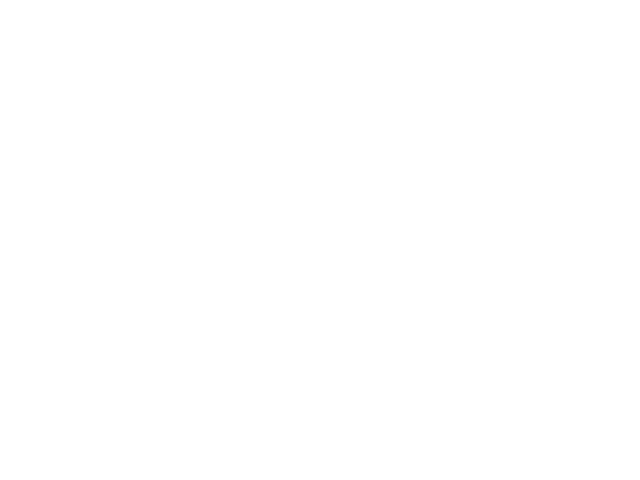

In [16]:
%matplotlib notebook

plt.figure()
plt.scatter(dataset_eval.parameters["distances"], losses - ref_losses)

In [ ]:
pd.DataFrame().from_dict(
    {"distances": dataset_eval.parameters["distances"], "errors": np.maximum(losses - ref_losses, 0)}
).to_csv(f"{load_path}/evaluation_interpolation.csv", index=False)

In [ ]:
np.mean(losses - ref_losses)

# PCA

In [ ]:
dataset_test = PrecomputedDatasetWithTransform(
    load_path=code_path / "test_data" / "klein_bottle_max_30000.pickle",
    sample_tuples=False,
    transform=lambda x: renderer.render(to_torch_and_device(x, device)),
)
dataloader_test = MultiIndexDataLoader(dataset_test, batch_size=args["test"]["batch_size"], shuffle=False)

In [ ]:
try:
    latent_codes = np.load(f"{load_path}/latent_points_random.npy")
except FileNotFoundError:
    with torch.no_grad():
        latent_codes = batched_forward(dataloader_test, encoder)
    np.save(f"{load_path}/latent_points_random.npy", latent_codes)

In [ ]:
pca = PCA()
pca_codes = pca.fit_transform(latent_codes)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
num_components = get_num_components(pca.explained_variance_ratio_, 0.99)

In [ ]:
num_components

In [ ]:
plt.figure()
plt.plot(stable_cumsum(pca.explained_variance_ratio_))

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_)

In [ ]:
pd.DataFrame(data=pca.explained_variance_, columns=["var"]).to_csv(load_path / "exp_var.csv", index_label="c")
pd.DataFrame(data=np.cumsum(pca.explained_variance_ratio_), columns=["var"]).to_csv(
    load_path / "exp_var_sum.csv", index_label="c"
)

In [ ]:
parameters_x = dataset_test.parameters["x"]
parameters_y = dataset_test.parameters["y"]

In [ ]:
klein_bottle = MANIFOLDS["klein_bottle"]()

In [ ]:
num = 2500

In [ ]:
dataset_test_num = PrecomputedDatasetWithTransform(
    load_path=code_path / "test_data" / "klein_bottle_max_30000.pickle",
    sample_tuples=True,
    transform=lambda x: renderer.render(to_torch_and_device(x, device)),
    num_samples=num,
)
dataloader_test_num = MultiIndexDataLoader(dataset_test_num, batch_size=args["test"]["batch_size"], shuffle=False)

In [ ]:
with torch.no_grad():
    latent_codes_xy = batched_forward_tuples(dataloader_test_num, encoder, used_images=("x", "y"))

In [ ]:
latent_codes_x = latent_codes_xy["x"]
latent_codes_y = latent_codes_xy["y"]

In [ ]:
distances_latent = np.sum((latent_codes_x - latent_codes_y) ** 2, axis=1) ** 0.5 / 4

In [ ]:
distances_true = dataset_test_num.parameters["distances"]

In [ ]:
plt.figure()
plt.scatter(distances_true, distances_latent)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"distances_true": distances_true, "distances_latent": distances_latent})

In [ ]:
df.to_csv(f"{load_path}/scatter_distances.csv", index=False)